In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import pandas as pd
pd.options.display.max_rows = 1000
import gc
import numpy as np
from tqdm import tqdm
from glob import glob
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import SparseAdam, Adam
torch.backends.cudnn.benchmark = True
print(torch.__version__)
import cudf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pickle
import random
import math
import time

def freemem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    gc.collect()
    return

device = 'cuda'
USE_GPU = torch.cuda.is_available()
print('Is GPU available?', USE_GPU)

1.13.1+cu117
Is GPU available? True


In [2]:
# !pip uninstall torch -y
# !pip install torch==1.12.1 torchvision torchaudio
files = (
    list(glob('fold/train-full-split*')) +
    list(glob('fold/valid-trim-split*')) +
    list(glob('fold/test-full-split*')) +
    list(glob('fold/test-trim-extra*')) +
    list(glob('fold/test-trim-split*'))
)
print(len(files))

119


In [3]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, True]).reset_index(drop=True)

#train['ids'] = np.arange(train.shape[0])
train['n'] = train.groupby('session')['ts'].cumcount()
train['day'] = train['ts'] - train['ts'].min()
train['day'] = ((train['day']-4*60*60) // (24*60*60)).astype('int8') 
train['day'] = train['day'].clip(0, 100)
train['hour'] = (train['ts'] // (60*60)).astype('int32') 
freemem(train)

print(train.shape)
train.head()

(216395289, 7)


session      aid          ts  type  n  day    hour
0        0  1517085  1659304800     0  0    0  460918
1        0  1563459  1659304904     0  1    0  460918
2        0  1309446  1659367439     0  2    0  460935
3        0    16246  1659367719     0  3    0  460935
4        0  1781822  1659367871     0  4    0  460935

In [4]:
dt = train.loc[train.type==2].groupby(['day', 'hour'])['ts'].count().to_pandas().reset_index().sort_values(['day','hour']).reset_index(drop=True)
dt

day    hour     ts
0      0  460918   3798
1      0  460919   1719
2      0  460920    833
3      0  460921    560
4      0  460922    542
5      0  460923    881
6      0  460924   2163
7      0  460925   3965
8      0  460926   5681
9      0  460927   7463
10     0  460928   9026
11     0  460929   9698
12     0  460930   9949
13     0  460931  10194
14     0  460932  10339
15     0  460933  10369
16     0  460934  11282
17     0  460935  11804
18     0  460936  11901
19     0  460937  13643
20     0  460938  16278
21     0  460939  17989
22     0  460940  13599
23     0  460941   5957
24     0  460942   3519
25     0  460943   1672
26     0  460944    885
27     0  460945    541
28     1  460946    581
29     1  460947   1069
30     1  460948   2574
31     1  460949   4932
32     1  460950   6235
33     1  460951   7969
34     1  460952   8628
35     1  460953   9477
36     1  460954   9261
37     1  460955   9929
38     1  460956  10172
39     1  460957   9888
40     1  460958  10410
41     1  460959  10810
42     1  460960  11040
43     1  460961  11592
44     1  460962  13757
45     1  460963  13759
46     1  460964  11832
47     1  460965   7792
48     1  460966   3459
49     1  460967   1815
50     1  460968    862
51     1  460969    609
52     2  460970    587
53     2  460971   1171
54     2  460972   2824
55     2  460973   5195
56     2  460974   6903
57     2  460975   8323
58     2  460976   9807
59     2  460977  10793
60     2  460978  10665
61     2  460979  11775
62     2  460980  11229
63     2  460981  12451
64     2  460982  12755
65     2  460983  12635
66     2  460984  11900
67     2  460985  12782
68     2  460986  13701
69     2  460987  14265
70     2  460988  13267
71     2  460989   7383
72     2  460990   3697
73     2  460991   1692
74     2  460992    972
75     2  460993    587
76     3  460994    634
77     3  460995   1100
78     3  460996   2669
79     3  460997   4755
80     3  460998   6481
81     3  460999   8532
82     3  461000   9921
83     3  461001  10320
84     3  461002  10566
85     3  461003  10628
86     3  461004  10561
87     3  461005  10734
88     3  461006  11229
89     3  461007  11472
90     3  461008  10740
91     3  461009  10824
92     3  461010  11877
93     3  461011  11451
94     3  461012  10471
95     3  461013   6829
96     3  461014   3307
97     3  461015   1658
98     3  461016    779
99     3  461017    705
100    4  461018    576
101    4  461019   1080
102    4  461020   2334
103    4  461021   4178
104    4  461022   5809
105    4  461023   7234
106    4  461024   8741
107    4  461025   9200
108    4  461026   8862
109    4  461027   9223
110    4  461028   9587
111    4  461029  10075
112    4  461030  10147
113    4  461031  10019
114    4  461032   9205
115    4  461033   9476
116    4  461034  10207
117    4  461035  10854
118    4  461036   9106
119    4  461037   6204
120    4  461038   3220
121    4  461039   1714
122    4  461040    833
123    4  461041    606
124    5  461042    395
125    5  461043    607
126    5  461044   1377
127    5  461045   3104
128    5  461046   5363
129    5  461047   7303
130    5  461048   8626
131    5  461049   9598
132    5  461050   9348
133    5  461051   9526
134    5  461052  10040
135    5  461053   9164
136    5  461054   9609
137    5  461055   9557
138    5  461056   8848
139    5  461057   8968
140    5  461058   8635
141    5  461059   9021
142    5  461060   8568
143    5  461061   6110
144    5  461062   3237
145    5  461063   1772
146    5  461064    853
147    5  461065    568
148    6  461066    395
149    6  461067    405
150    6  461068    904
151    6  461069   2369
152    6  461070   5067
153    6  461071   7818
154    6  461072  10201
155    6  461073  12365
156    6  461074  13297
157    6  461075  13532
158    6  461076  13135
159    6  461077  12496
160    6  461078  11874
161    6  461079  12591
162    6  461080  12060
163    6  461081  13135
164    6  461082  14533
165    6  461083  149

<AxesSubplot: xlabel='hour'>

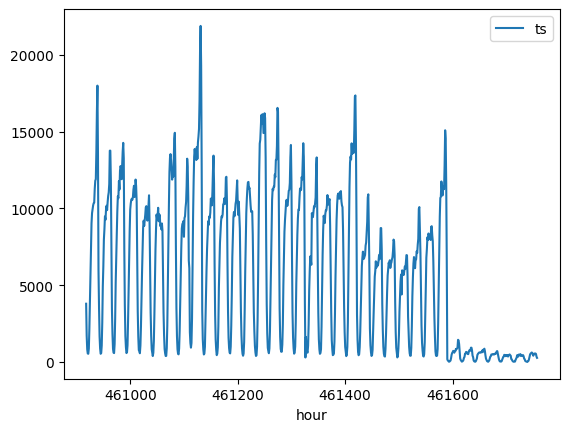

In [5]:
dt.plot(x='hour', y='ts')

In [6]:
train['sid'] = (train['session'] * 35 + train['day']).factorize()[0]
train['sid'].nunique()

36642062

In [7]:
train['prev_type'] = train.groupby('sid')['type'].shift(1).fillna(0)
train['delta_sid'] = train.groupby('sid')['ts'].shift(1)
train['delta_sid'] = ((train['ts'] - train['delta_sid']).fillna(0) // (2*60*60)).astype('int8')
train.loc[train.delta_sid  <3, 'delta_sid'] = 0
train.loc[(train.delta_sid>=3)|((train.type==0)&(train.prev_type==2)&(train.delta_sid>0)), 'delta_sid'] = 1
train['delta_sid'] = train.groupby('sid')['delta_sid'].cumsum()
del train['prev_type']
train['sid'] = (train['sid'] * 10 + train['delta_sid']).factorize()[0]
del train['delta_sid']
train['sid'].nunique()

39095330

In [8]:
#train['delta_sid'].value_counts()

In [9]:
train.tail(60)

session      aid          ts  type  n  day    hour       sid
216395229  14571529   533638  1662328703     0  0   34  461757  39095277
216395230  14571530  1455001  1662328704     0  0   34  461757  39095278
216395231  14571531  1677894  1662328705     0  0   34  461757  39095279
216395232  14571532   126803  1662328708     0  0   34  461757  39095280
216395233  14571533   229094  1662328708     0  0   34  461757  39095281
216395234  14571533   893173  1662328754     0  1   34  461757  39095281
216395235  14571534   272221  1662328709     0  0   34  461757  39095282
216395236  14571534   272221  1662328716     1  1   34  461757  39095282
216395237  14571534   272221  1662328720     1  2   34  461757  39095282
216395238  14571534  1152891  1662328727     0  3   34  461757  39095282
216395239  14571535  1202665  1662328709     0  0   34  461757  39095283
216395240  14571536  1772628  1662328711     0  0   34  461757  39095284
216395241  14571537   629253  1662328713     0  0   34  461757  39095285
216395242  14571538   457494  1662328716     0  0   34  461757  39095286
216395243  14571539   317311  1662328717     0  0   34  461757  39095287
216395244  14571539   317311  1662328765     0  1   34  461757  39095287
216395245  14571540    72743  1662328719     0  0   34  461757  39095288
216395246  14571541   316236  1662328721     0  0   34  461757  39095289
216395247  14571542  1771616  1662328721     0  0   34  461757  39095290
216395248  14571543   460611  1662328722     0  0   34  461757  39095291
216395249  14571544   854413  1662328723     0  0   34  461757  39095292
216395250  14571545   430758  1662328726     0  0   34  461757  39095293
216395251  14571546   238274  1662328727     0  0   34  461757  39095294
216395252  14571547  1546409  1662328727     0  0   34  461757  39095295
216395253  14571547  1117925  1662328764     0  1   34  461757  39095295
216395254  14571548  1453906  1662328728     0  0   34  461757  39095296
216395255  14571548  1798580  1662328744     0  1   34  461757  39095296
216395256  14571549   576462  1662328731     0  0   34  461757  39095297
216395257  14571550    52785  1662328733     0  0   34  461757  39095298
216395258  14571551   378686  1662328735     0  0   34  461757  39095299
216395259  14571552  1771744  1662328737     0  0   34  461757  39095300
216395260  14571553   556636  1662328740     0  0   34  461757  39095301
216395261  14571554  1722993  1662328740     0  0   34  461757  39095302
216395262  14571555  1278483  1662328746     0  0   34  461757  39095303
216395263  14571556    27575  1662328747     0  0   34  461757  39095304
216395264  14571557  1156575  1662328747     0  0   34  461757  39095305
216395265  14571558   333699  1662328747     0  0   34  461757  39095306
216395266  14571559  1503039  1662328752     0  0   34  461757  39095307
216395267  14571560  1644433  1662328752     0  0   34  461757  39095308
216395268  14571561   975840  1662328752     0  0   34  461757  39095309
216395269  14571562   313383  1662328753     0  0   34  461757  39095310
216395270  14571563  1102089  1662328755     0  0   34  461757  39095311
216395271  14571564  1824122  1662328756     0  0   34  461757  39095312
216395272  14571565   368809  1662328756     0  0   34  461757  39095313
216395273  14571566  1157982  1662328759     0  0   34  461757  39095314
216395274  14571567  1190074  1662328762     0  0   34  461757  39095315
216395275  14571568     9981  1662328763     0  0   34  461757  39095316
216395276  14571569    27116  1662328764     0  0   34  461757  39095317
216395277  14571570   389613  1662328765     0  0   34  461757  39095318
216395278  14571571    60347  1662328766     0  0   34  461757  39095319
216395279  14571572   986164  1662328766     0  0   34  461757  39095320
216395280  14571573  1823537  1662328767     0  0   34  461757  39095321
216395281  14571574   306024  1662328769     0  0   34  461757  39095322
216395282  14571575  1257071  1662328771     0  0   34  461757  390953

In [10]:
# train['isorder'] = train.groupby('sid')['type'].transform('max')
# train.head(60)

In [11]:
# dt = train.groupby(['sid'])['isorder'].max()
# dt.value_counts()

In [12]:
# train.loc[train.isorder>0].head(60)

In [13]:
train = train.loc[train.type==0].reset_index(drop=True)
gc.collect()

91

In [14]:
for lag in range(4, -1, -1):
    train[f'lag{lag}'] = train.groupby('sid')['aid'].shift(lag).fillna(lag)

for lag in range(1, 6):
    train[f'led{lag}'] = train.groupby('sid')['aid'].shift(-lag).fillna(lag)
    
del train['aid']
gc.collect()
train.head(60)

session          ts  type   n  day    hour  sid     lag4     lag3  \
0         0  1659304800     0   0    0  460918    0        4        3   
1         0  1659304904     0   1    0  460918    0        4        3   
2         0  1659367439     0   2    0  460935    1        4        3   
3         0  1659367719     0   3    0  460935    1        4        3   
4         0  1659367871     0   4    0  460935    1        4        3   
5         0  1659367885     0   5    0  460935    1        4  1309446   
6         0  1659370064     0  10    0  460936    1  1309446    16246   
7         0  1659370067     0  11    0  460936    1    16246  1781822   
8         0  1659371003     0  12    0  460936    1  1781822  1152674   
9         0  1659371033     0  13    0  460936    1  1152674   362233   
10        0  1659371042     0  14    0  460936    1   362233  1649869   
11        0  1659371044     0  15    0  460936    1  1649869  1649869   
12        0  1659371104     0  16    0  460936    1  1649869   984597   
13        0  1659371123     0  17    0  460936    1   984597  1649869   
14        0  1659375531     0  18    0  460937    1  1649869   803544   
15        0  1659375544     0  19    0  460937    1   803544  1110941   
16        0  1659380437     0  20    0  460939    1  1110941  1190046   
17        0  1659385092     0  21    0  460940    1  1190046  1760685   
18        0  1659457550     0  22    1  460960    2        4        3   
19        0  1659457555     0  23    1  460960    2        4        3   
20        0  1659457556     0  24    1  460960    2        4        3   
21        0  1659457682     0  25    1  460960    2        4  1650637   
22        0  1659457782     0  26    1  460960    2  1650637   313546   
23        0  1659457834     0  27    1  460960    2   313546  1650637   
24        0  1659457854     0  28    1  460960    2  1650637   979517   
25        0  1659457862     0  29    1  460960    2   979517   351157   
26        0  1659531937     0  30    2  460981    3        4        3   
27        0  1659626326     0  31    3  461007    4        4        3   
28        0  1659626335     0  32    3  461007    4        4        3   
29        0  1659627788     0  33    3  461007    4        4        3   
30        0  1659627805     0  34    3  461007    4        4   305831   
31        0  1659632910     0  35    3  461009    4   305831  1110548   
32        0  1659639917     0  36    3  461011    4  1110548  1110548   
33        0  1659640759     0  37    3  461011    4  1110548   305831   
34        0  1659640798     0  38    3  461011    4   305831  1650114   
35        0  1659640818     0  39    3  461011    4  1650114  1604396   
36        0  1659640824     0  40    3  461011    4  1604396  1009750   
37        0  1659644609     0  41    3  461012    4  1009750  1800933   
38        0  1659710146     0  42    4  461030    5        4        3   
39        0  1659710161     0  44    4  461030    5        4        3   
40        0  1659710180     0  45    4  461030    5        4        3   
41        0  1659710277     0  46    4  461030    5        4   789245   
42        0  1659710348     0  47    4  461030    5   789245   366890   
43        0  1659710506     0  48    4  461030    5   366890   361317   
44        0  1659710544     0  49    4  461030    5   361317  1700164   
45        0  1659710615     0  50    4  461030    5  1700164  1755597   
46        0  1659710636     0  51    4  461030    5  1755597   789245   
47        0  1659710643     0  52    4  461030    5   789245   784978   
48        0  1659710660     0  53    4  461030    5   784978  1171505   
49        0  1659729979     0  54    4  461036    5  1171505   784978   
50        0  1659774028     0  55    5  461048    6        4        3   
51        0  1659774232     0  56    5  461048    6        4        3   
52        0  1659774337     0  57    5  461048    6        4        3   
53        0  1659774357     0  58    5  461048    6        4  

In [15]:
print(train.shape)
train = train.loc[train['led1']!=1].reset_index(drop=True)
gc.collect()
print(train.shape)
train.head()

(194722062, 17)
(155736606, 17)


session          ts  type  n  day    hour  sid  lag4     lag3     lag2  \
0        0  1659304800     0  0    0  460918    0     4        3        2   
1        0  1659367439     0  2    0  460935    1     4        3        2   
2        0  1659367719     0  3    0  460935    1     4        3        2   
3        0  1659367871     0  4    0  460935    1     4        3  1309446   
4        0  1659367885     0  5    0  460935    1     4  1309446    16246   

      lag1     lag0     led1     led2     led3     led4     led5  
0        1  1517085  1563459        2        3        4        5  
1        1  1309446    16246  1781822  1152674   362233  1649869  
2  1309446    16246  1781822  1152674   362233  1649869  1649869  
3    16246  1781822  1152674   362233  1649869  1649869   984597  
4  1781822  1152674   362233  1649869  1649869   984597  1649869

In [16]:
del train['ts'], train['n'], train['sid']
gc.collect()
train.to_pandas().to_parquet('train-proc-1.parquet'); gc.collect()

0

In [3]:
train = pd.read_parquet('train-proc-1.parquet'); gc.collect()
print(train.shape)
print(train.head())

(155736606, 14)
   session  type  day    hour  lag4     lag3     lag2     lag1     lag0  \
0        0     0    0  460918     4        3        2        1  1517085   
1        0     0    0  460935     4        3        2        1  1309446   
2        0     0    0  460935     4        3        2  1309446    16246   
3        0     0    0  460935     4        3  1309446    16246  1781822   
4        0     0    0  460935     4  1309446    16246  1781822  1152674   

      led1     led2     led3     led4     led5  
0  1563459        2        3        4        5  
1    16246  1781822  1152674   362233  1649869  
2  1781822  1152674   362233  1649869  1649869  
3  1152674   362233  1649869  1649869   984597  
4   362233  1649869  1649869   984597  1649869  


In [4]:
train['lag0'].max(), train['type'].max(), train['day'].max(), train['hour'].max()

(1855602, 0, 34, 461757)

In [5]:
train.columns

Index(['session', 'type', 'day', 'hour', 'lag4', 'lag3', 'lag2', 'lag1',
       'lag0', 'led1', 'led2', 'led3', 'led4', 'led5'],
      dtype='object')

In [6]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_aids=1855602+1, n_factors=32):
        super().__init__()
        self.aid_emb = nn.Embedding(1855602+1, n_factors, sparse=True)
        self.day_emb = nn.Embedding(35 , n_factors, sparse=True)
        self.aid_emb.weight.data.normal_(mean=0.0, std=0.001)
        self.day_emb.weight.data.normal_(mean=0.0, std=0.001)
        
    def forward(self, lags, targets, days):
        e1, tgt = self.get_emb(lags, targets, days)
        out1 = (e1 * tgt)
        return out1.sum(dim=1).sigmoid()    

    def get_emb(self, lags, targets, days):
        e1 = self.aid_emb(lags) 
        tgt = self.aid_emb(targets)
        d1 = self.day_emb(days) 
        e1 = 2*e1[:,0] + 3*e1[:,1] + 4*e1[:,2] + 5*e1[:,3] + 6*e1[:,4] + d1
        tgt = 6*tgt[:,0] + 5*tgt[:,1] + 4*tgt[:,2] + 3*tgt[:,3] + 2*tgt[:,4]  + d1
        e1 = torch.nn.functional.normalize(e1)
        tgt = torch.nn.functional.normalize(tgt)
        return e1, tgt

model = MatrixFactorization(n_aids=1855602+1, n_factors=32)
model

MatrixFactorization(
  (aid_emb): Embedding(1855603, 32, sparse=True)
  (day_emb): Embedding(35, 32, sparse=True)
)

In [7]:
lags = (1855603 * torch.rand(3, 5)).long()
targets = (1855603 * torch.rand(3, 5)).long()
days = (34 * torch.rand(3)).long()
lags

tensor([[1421917, 1713777,  122060, 1202309,  903949],
        [1343644, 1813130, 1772989, 1597321, 1663870],
        [ 277390,  294026,  993252,  952957,  713897]])

In [8]:
model(lags, targets, days)

tensor([0.5091, 0.4928, 0.5348], grad_fn=<SigmoidBackward0>)

In [9]:
train.head()

session  type  day    hour  lag4     lag3     lag2     lag1     lag0  \
0        0     0    0  460918     4        3        2        1  1517085   
1        0     0    0  460935     4        3        2        1  1309446   
2        0     0    0  460935     4        3        2  1309446    16246   
3        0     0    0  460935     4        3  1309446    16246  1781822   
4        0     0    0  460935     4  1309446    16246  1781822  1152674   

      led1     led2     led3     led4     led5  
0  1563459        2        3        4        5  
1    16246  1781822  1152674   362233  1649869  
2  1781822  1152674   362233  1649869  1649869  
3  1152674   362233  1649869  1649869   984597  
4   362233  1649869  1649869   984597  1649869

In [10]:
def train_loop(model, iterator, optimizer, clip):
    
    criterion = nn.BCELoss().to(device)
    model.train()
    epoch_loss = 0.
    gc.collect()
    with tqdm(enumerate(iterator), total=len(iterator), miniters=100) as pbar:
        for i, (data, target) in pbar:    
            data, days, target = data[:,:5].to(device), data[:,5].to(device), target.to(device)
            
            optimizer.zero_grad()
            output_pos = model(data, target, days)
            
            #Shuffle target to build negative samples
            target = target[torch.randperm(target.shape[0])]
            output_neg = model(data, target, days)
            
            outputs = torch.cat([output_pos, output_neg])
            targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_neg)])
            loss = criterion(outputs, targets)
            
            del data, target

            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            epoch_loss += loss.item()
            cumloss = epoch_loss / (i+1)
            pbar.set_description(f"Loss {cumloss:.5f}")
    
    gc.collect()  
    return epoch_loss / len(iterator)


def valid_loop(model, iterator):
    ypred = []
    ytarget = []    
    epoch_loss = 0.

    model.eval()
    criterion = nn.BCELoss().to(device)
    with torch.no_grad():
        with tqdm(enumerate(iterator), total=len(iterator), miniters=50) as pbar:
            for i, (data, target) in pbar:    
                data, days, target = data[:,:5].to(device), data[:,5].to(device), target.to(device)
                
                output_pos = model(data, target, days)

                #Shuffle target to build negative samples
                target = target[torch.randperm(target.shape[0])]
                output_neg = model(data, target, days)

                outputs = torch.cat([output_pos, output_neg])
                targets = torch.cat([torch.ones_like(output_pos), torch.zeros_like(output_neg)])
                loss = criterion(outputs, targets)
                
                #ypred.append(output.cpu().numpy())
                #ytarget.append(target.cpu().numpy())
                del data, target

                epoch_loss += loss.item()
                cumloss = epoch_loss / (i+1)
                pbar.set_description(f"Loss {cumloss:.5f}")
                
    #ypred = np.concatenate(ypred)
    #ytarget = np.concatenate(ytarget)
    gc.collect()  
    
    #return ytarget, ypred , epoch_loss / len(iterator)
    return epoch_loss / len(iterator)

gc.collect()

0

In [11]:
train.shape, device

((155736606, 14), 'cuda')

In [12]:
valid = train.loc[(train.session % 400)==11].copy().reset_index()
valid.shape

(381986, 15)

In [13]:
train = train.loc[(train.session % 400)!=11].reset_index()
gc.collect()
train.shape

(155354620, 15)

In [14]:
train.head()

index  session  type  day    hour  lag4     lag3     lag2     lag1  \
0      0        0     0    0  460918     4        3        2        1   
1      1        0     0    0  460935     4        3        2        1   
2      2        0     0    0  460935     4        3        2  1309446   
3      3        0     0    0  460935     4        3  1309446    16246   
4      4        0     0    0  460935     4  1309446    16246  1781822   

      lag0     led1     led2     led3     led4     led5  
0  1517085  1563459        2        3        4        5  
1  1309446    16246  1781822  1152674   362233  1649869  
2    16246  1781822  1152674   362233  1649869  1649869  
3  1781822  1152674   362233  1649869  1649869   984597  
4  1152674   362233  1649869  1649869   984597  1649869

In [15]:
train.dtypes

index      int64
session    int32
type        int8
day         int8
hour       int32
lag4       int32
lag3       int32
lag2       int32
lag1       int32
lag0       int32
led1       int32
led2       int32
led3       int32
led4       int32
led5       int32
dtype: object

In [16]:
TRAIN = train[['lag4', 'lag3', 'lag2', 'lag1', 'lag0', 'day']].values.copy()
VALID = valid[['lag4', 'lag3', 'lag2', 'lag1', 'lag0', 'day']].values.copy()
TRAIN_TARGET = train[['led1', 'led2', 'led3', 'led4', 'led5']].values.copy()
VALID_TARGET = valid[['led1', 'led2', 'led3', 'led4', 'led5']].values.copy()
del train, valid; gc.collect()
TRAIN.shape, VALID.shape

((155354620, 6), (381986, 6))

In [17]:
TRAIN[100]

array([ 321397,  828625, 1624436, 1157411, 1537907,      16], dtype=int32)

In [18]:
model = MatrixFactorization(n_aids=1855602+1, n_factors=64).to(device)
#model.load_state_dict(torch.load('model-weights/fm_split_2_0.6040_v5.pt'))
optimizer = optim.SparseAdam(model.parameters(), lr=0.00002)
gc.collect()
print(model)

MatrixFactorization(
  (aid_emb): Embedding(1855603, 64, sparse=True)
  (day_emb): Embedding(35, 64, sparse=True)
)


In [19]:
from torch.utils.data import TensorDataset

BS = 8*32*32

train_ds = TensorDataset(torch.as_tensor(TRAIN).long(), torch.as_tensor(TRAIN_TARGET).long())
train_dl = DataLoader(train_ds, BS, True, num_workers=2, drop_last=True, pin_memory=True)

valid_ds = TensorDataset(torch.as_tensor(VALID).long(), torch.as_tensor(VALID_TARGET).long())
valid_dl = DataLoader(valid_ds, BS, False, num_workers=2, drop_last=False, pin_memory=True)

print(len(valid_ds), len(valid_dl))

381986 47


In [20]:
!mkdir model-weights
for epoch in range(0, 10):
    train_loop(model, train_dl, optimizer, 1000.); gc.collect()
    valloss = valid_loop(model, valid_dl); gc.collect()
    torch.save(model.state_dict(), f'model-weights/fm_split_{epoch}_{valloss:.4f}_v8.pt');gc.collect()
    print(epoch, valloss)

Loss 0.53436: 100%|██████████| 47/47 [00:03<00:00, 14.02it/s]


0 0.53435765428746


Loss 0.53174: 100%|██████████| 47/47 [00:03<00:00, 14.44it/s]


1 0.5317409888226935


Loss 0.53101: 100%|██████████| 47/47 [00:03<00:00, 15.05it/s]


2 0.5310066063353356


Loss 0.53049: 100%|██████████| 47/47 [00:03<00:00, 15.09it/s]


3 0.530487670543346


Loss 0.53011: 100%|██████████| 47/47 [00:03<00:00, 15.39it/s]


4 0.5301097200271931


Loss 0.52991: 100%|██████████| 47/47 [00:03<00:00, 15.33it/s]


5 0.529911182028182


Loss 0.52973: 100%|██████████| 47/47 [00:03<00:00, 15.06it/s]


6 0.529730516545316


Loss 0.52960: 100%|██████████| 47/47 [00:03<00:00, 15.20it/s]


7 0.5295972950915073


Loss 0.52950: 100%|██████████| 47/47 [00:03<00:00, 15.32it/s]


8 0.5294961865912092


Loss 0.52934: 100%|██████████| 47/47 [00:03<00:00, 15.16it/s]


9 0.5293442733744358


In [21]:
optimizer = optim.SparseAdam(model.parameters(), lr=0.000002)
for epoch in range(10, 20):
    train_loop(model, train_dl, optimizer, 1000.); gc.collect()
    valloss = valid_loop(model, valid_dl); gc.collect()
    torch.save(model.state_dict(), f'model-weights/fm_split_{epoch}_{valloss:.4f}_v8.pt');gc.collect()
    print(epoch, valloss)

Loss 0.52915: 100%|██████████| 47/47 [00:03<00:00, 15.28it/s]


10 0.5291456491389173


Loss 0.52872: 100%|██████████| 47/47 [00:03<00:00, 15.18it/s]


11 0.5287249303878622


Loss 0.52884: 100%|██████████| 47/47 [00:03<00:00, 14.94it/s]


12 0.5288447357238607


Loss 0.52869: 100%|██████████| 47/47 [00:03<00:00, 15.07it/s]


13 0.5286873084433535


Loss 0.52869: 100%|██████████| 47/47 [00:03<00:00, 14.57it/s]


14 0.5286857587225894


Loss 0.52871: 100%|██████████| 47/47 [00:03<00:00, 15.36it/s]


15 0.5287054066962384


Loss 0.52879: 100%|██████████| 47/47 [00:03<00:00, 15.32it/s]


16 0.5287854430523324


Loss 0.52870: 100%|██████████| 47/47 [00:03<00:00, 15.26it/s]


17 0.5287018976313003


Loss 0.52843: 100%|██████████| 47/47 [00:03<00:00, 14.52it/s]


18 0.5284334192884729


Loss 0.52887: 100%|██████████| 47/47 [00:03<00:00, 15.24it/s]


19 0.5288660970140011


In [23]:
print(epoch, valloss)
#19 0.5294631500633395
#19 0.5288660970140011

19 0.5288660970140011


In [46]:
model = MatrixFactorization(n_aids=1855602+1, n_factors=64).to(device)
model.load_state_dict(torch.load('model-weights/fm_split_18_0.5284_v8.pt'))

with torch.no_grad():
    embeddings = model.aid_emb.weight
    #embeddings = torch.nn.functional.normalize(embeddings, p=2.0, dim=1, eps=1e-12)
    embeddings = embeddings.detach().cpu().numpy()
    
    embeddings_day = model.day_emb.weight
    #embeddings_day = torch.nn.functional.normalize(embeddings_day, p=2.0, dim=1, eps=1e-12)
    embeddings_day = embeddings_day.detach().cpu().numpy()
    
np.save('oof/embbedings_fm_split_18_0.5284_v8.npy', embeddings)
np.save('oof/embbedings_day_fm_split_18_0.5284_v8.npy', embeddings_day)
embeddings.shape, embeddings_day.shape

((1855603, 64), (35, 64))

In [94]:
embeddings = np.load('oof/embbedings_fm_split_18_0.5284_v8.npy')
embeddings_day = np.load('oof/embbedings_day_fm_split_18_0.5284_v8.npy')
embeddings.shape, embeddings_day.shape

((1855603, 64), (35, 64))

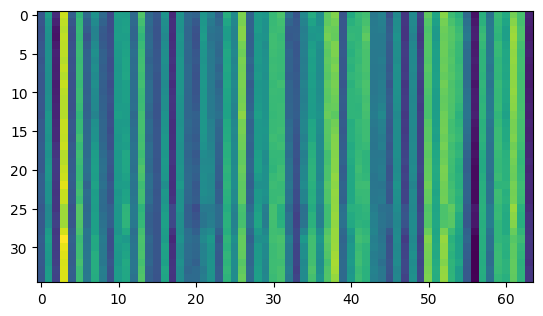

In [95]:
import matplotlib.pyplot as plt
plt.imshow(embeddings_day)

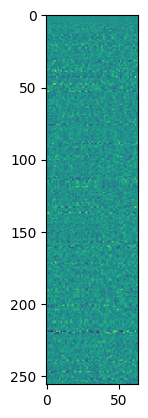

In [49]:
import matplotlib.pyplot as plt
plt.imshow(embeddings[:256])

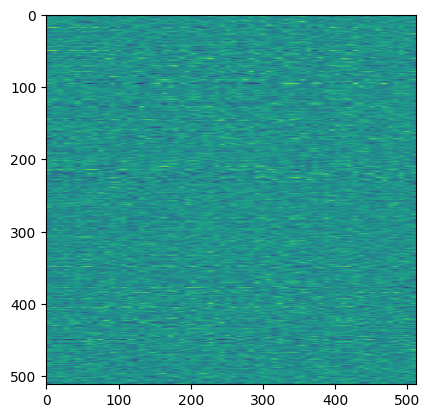

In [50]:
import cv2
plt.imshow( cv2.resize(embeddings[:200000], (512,512)) )

In [52]:
embeddings_day.shape

(35, 64)

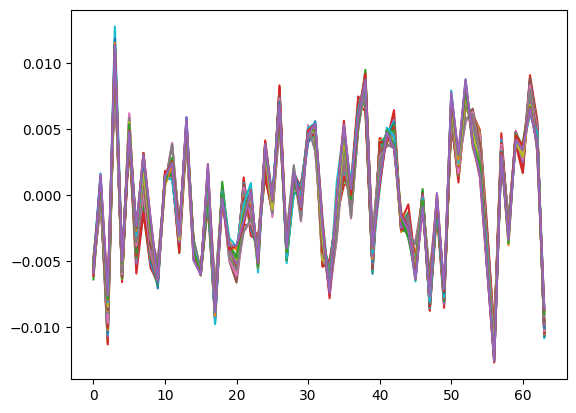

In [53]:
for i in range(35):
    plt.plot( embeddings_day[i] )

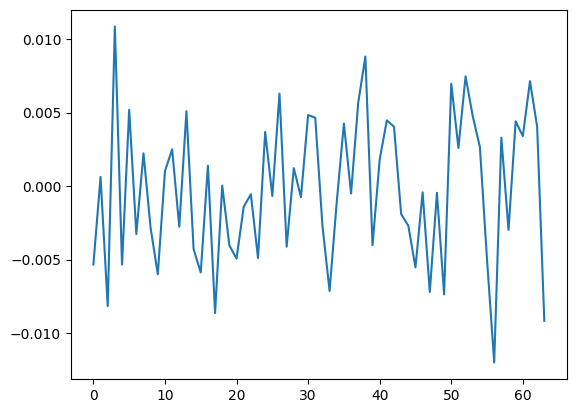

In [54]:
embeddings_day = np.mean(embeddings_day[-14:], 0)
plt.plot(embeddings_day)

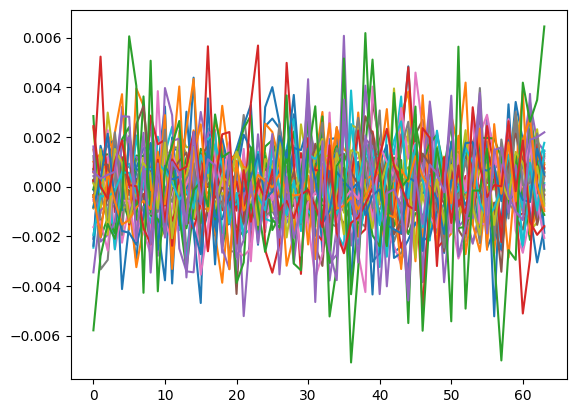

In [55]:
for i in range(35):
    plt.plot( embeddings[i] )

In [56]:
t = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
torch.nn.functional.normalize(t, p=2.0, dim = 1)

tensor([[0.2673, 0.5345, 0.8018],
        [0.4558, 0.5698, 0.6838]])

In [57]:
def normalize(v):
    if len(v.shape)>1:
        return v / np.sqrt(np.sum(v**2, 1 , keepdims=True))
    else:
        return v / np.sqrt(np.sum(v**2))

t = np.array([[1.,2.,3.],[4.,5.,6.]])
normalize(t)

array([[0.26726124, 0.53452248, 0.80178373],
       [0.45584231, 0.56980288, 0.68376346]])

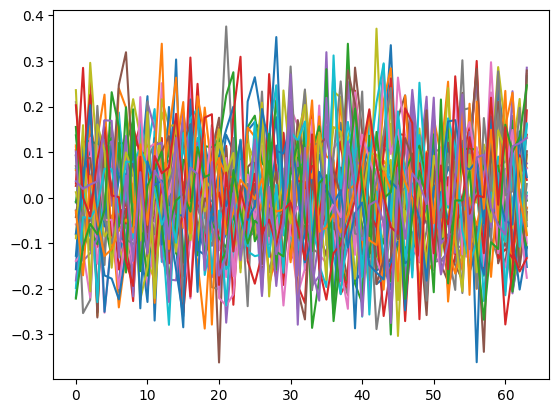

In [58]:
for i in range(35):
    plt.plot( normalize(embeddings[i]) )

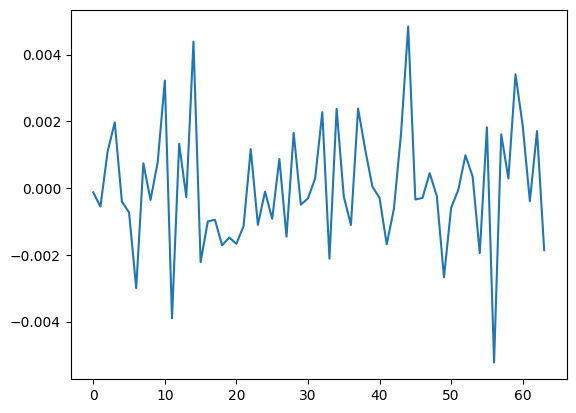

In [59]:
plt.plot(embeddings[0])

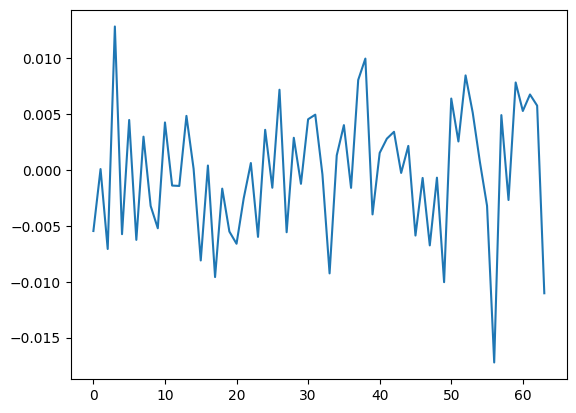

In [60]:
embeddings += embeddings_day
plt.plot(embeddings[0])

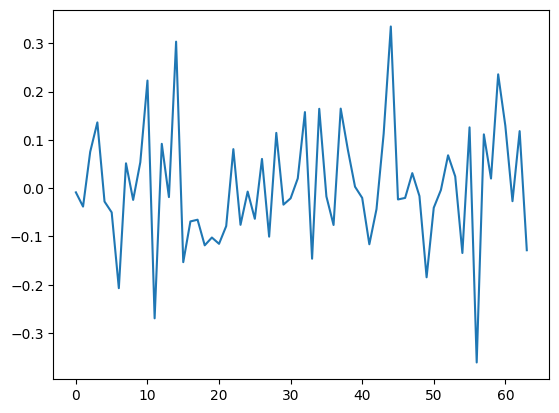

In [96]:
embeddings = normalize(embeddings)
plt.plot(embeddings[0])

In [63]:
%%time
import cuml
from cuml.manifold import TSNE
tsne    = TSNE(n_components=2, perplexity=50, learning_rate=200, n_neighbors=5*50)
tsne_aid0 = tsne.fit_transform(embeddings)
tsne_aid0.shape, np.min(tsne_aid0), np.max(tsne_aid0)

[W] [12:42:30.806099] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 2min 55s, sys: 1.48 s, total: 2min 57s
Wall time: 2min 56s


((1855603, 2), -9443.456, 10406.437)

In [66]:
tsne_aid0 = np.clip(tsne_aid0, -900, 900)

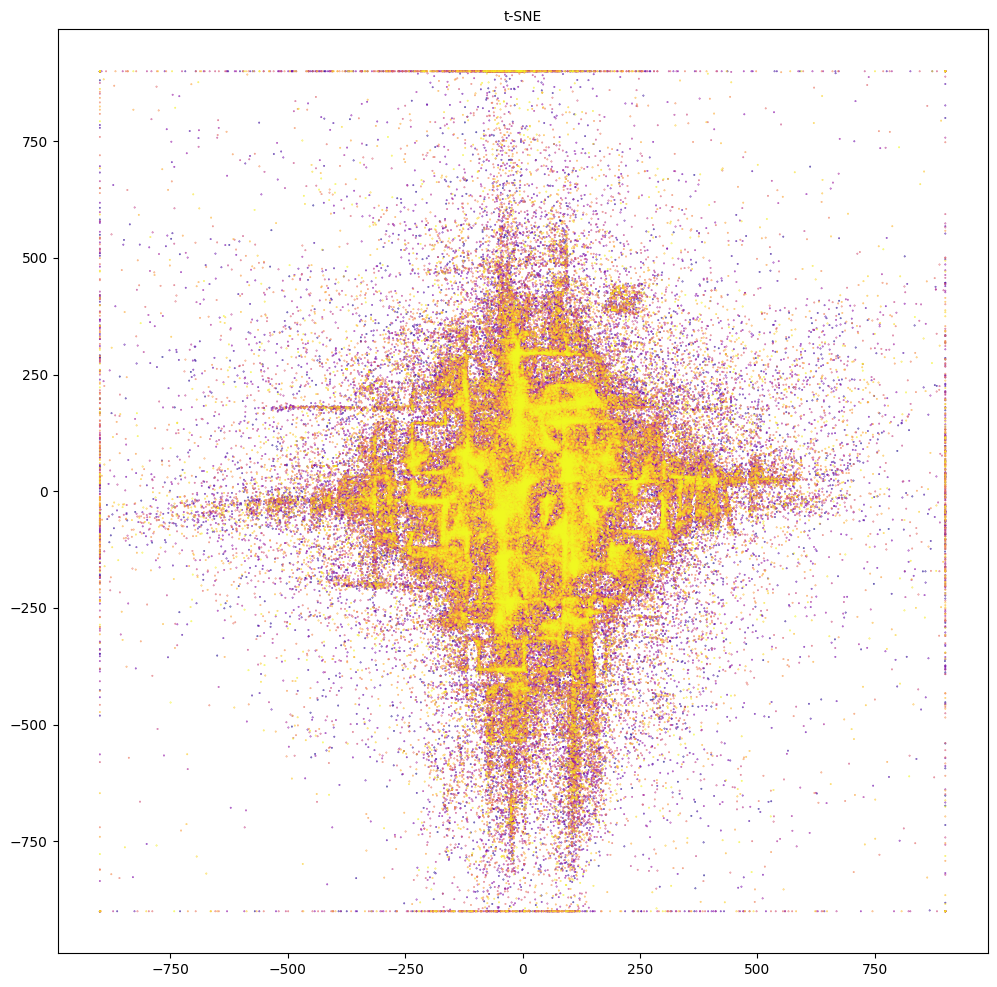

In [67]:
x = np.arange(tsne_aid0.shape[0])//7277
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=x, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

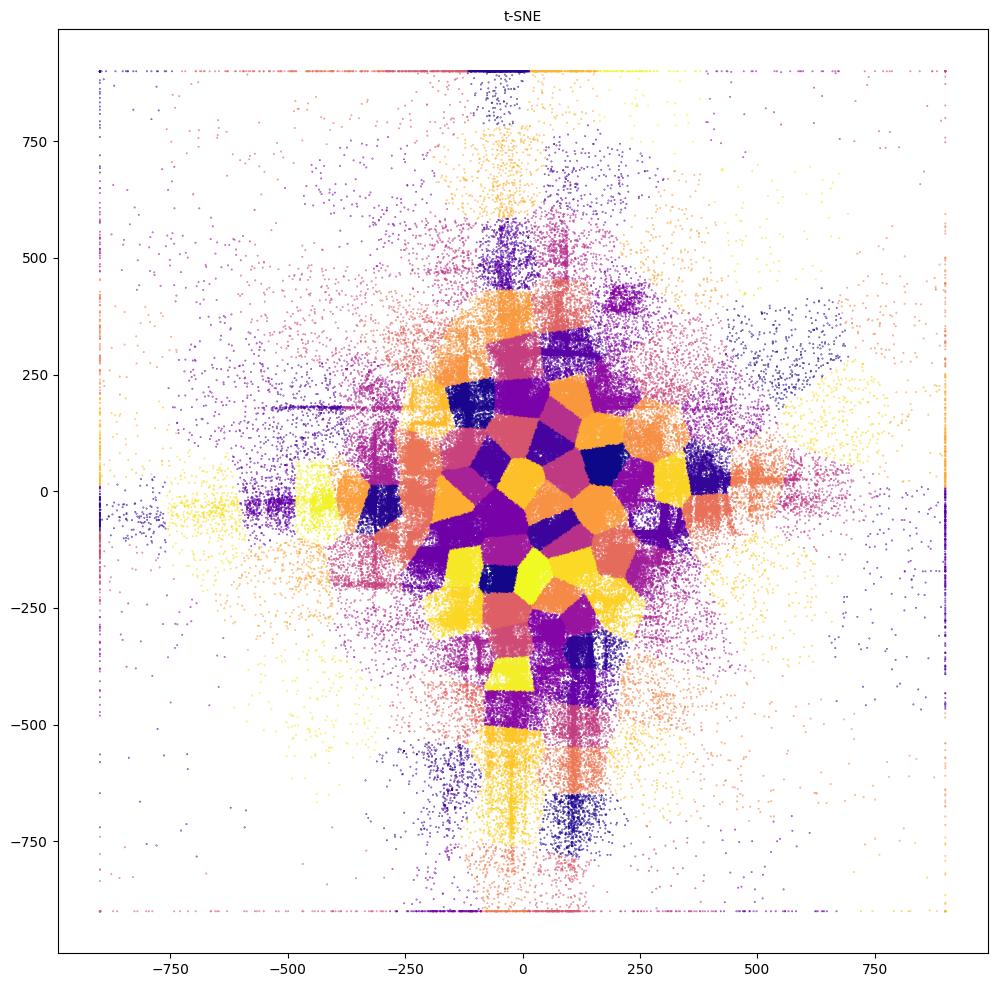

CPU times: user 1min 3s, sys: 2.21 s, total: 1min 6s
Wall time: 1min 4s


In [68]:
%%time
km = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
km.fit(tsne_aid0)
np.unique(km.labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km.labels_, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

In [69]:
# km = cuml.cluster.HDBSCAN(min_cluster_size=256, min_samples=2, cluster_selection_epsilon=0.0, max_cluster_size=0, metric='euclidean', alpha=1.0, p=2, verbose=True)
# km.fit(tsne_ses)
# np.unique(km.labels_, return_counts=True)

# fig, ax = plt.subplots(figsize=(12, 12))
# ax.scatter(tsne_ses[:,0], tsne_ses[:,1], s=0.1, c=km.labels_, cmap=plt.cm.plasma)
# ax.set_title('t-SNE', fontsize=10)
# plt.show();

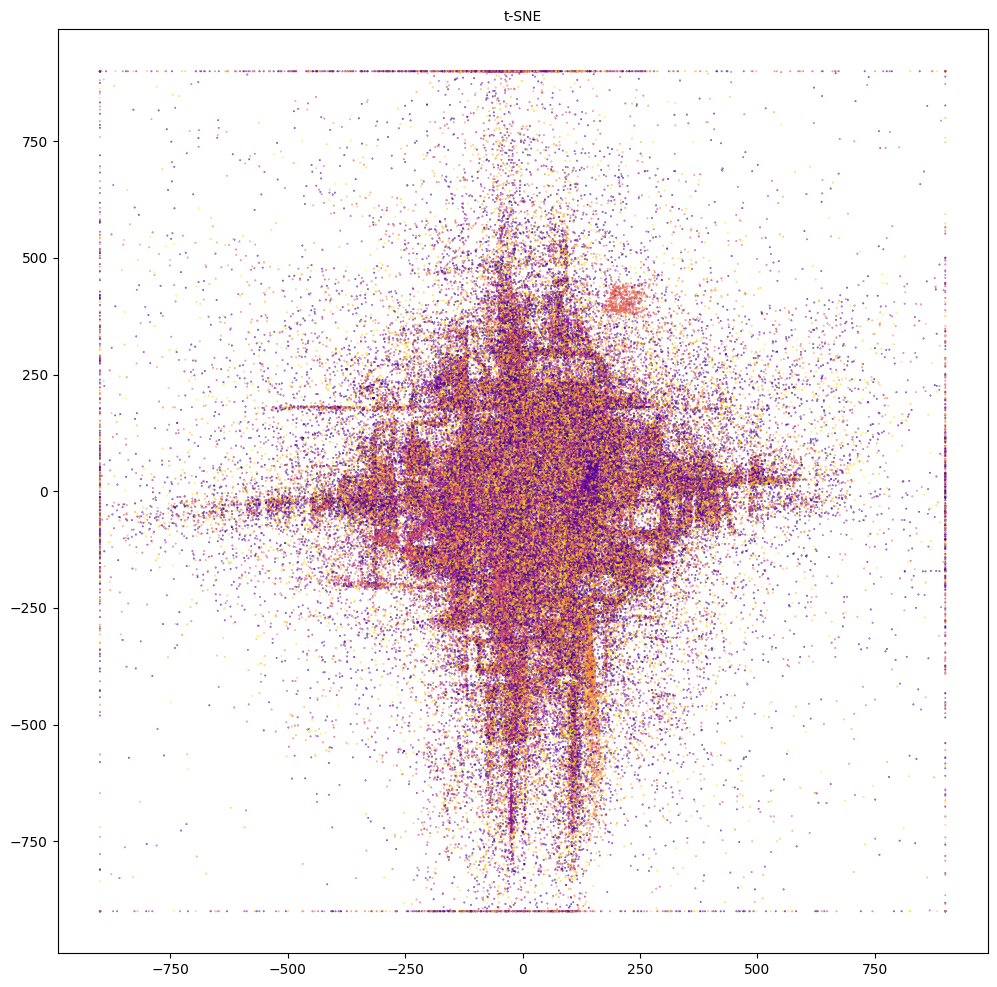

CPU times: user 53 s, sys: 2.61 s, total: 55.6 s
Wall time: 53.5 s


In [70]:
%%time
km1 = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
km1.fit(normalize(embeddings))
#np.unique(km1.labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km1.labels_, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

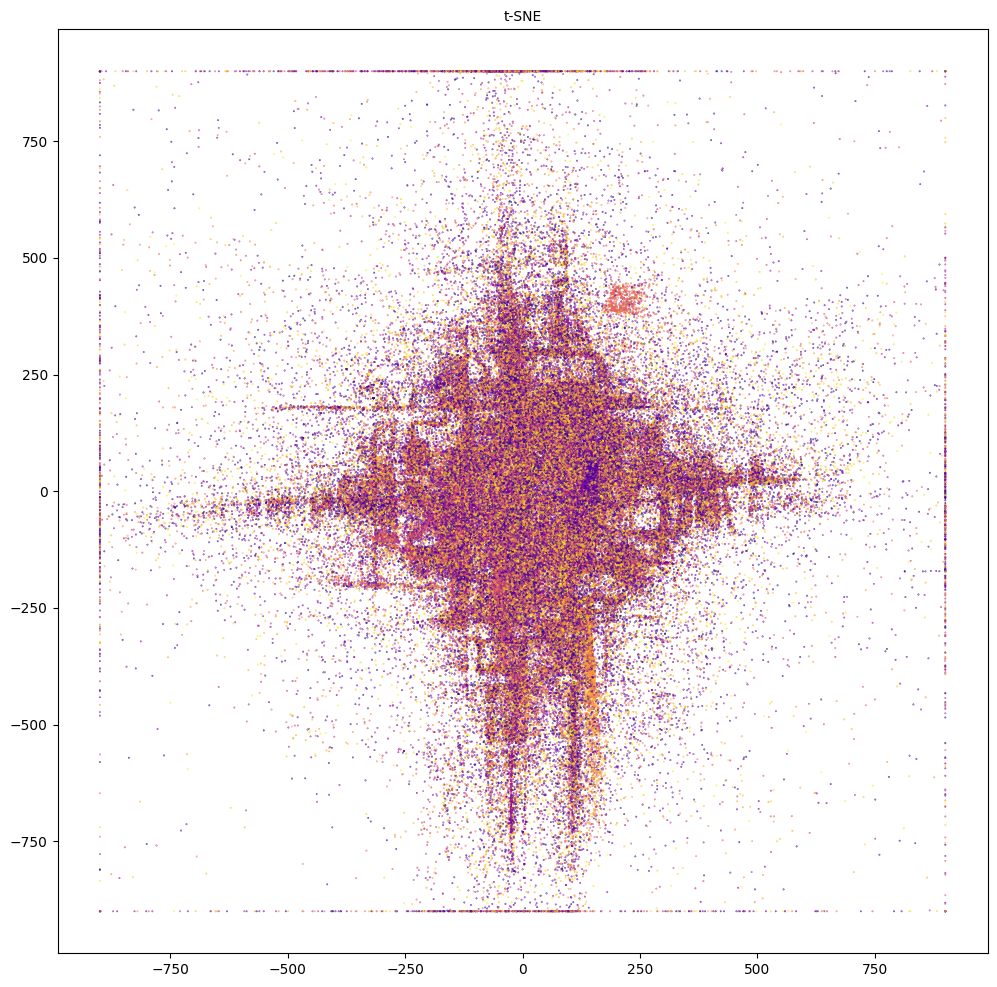

CPU times: user 52.6 s, sys: 2.34 s, total: 54.9 s
Wall time: 53.2 s


In [71]:
%%time
km1 = cuml.KMeans(n_clusters=128, max_iter=4000, n_init=8, oversampling_factor=4.0, max_samples_per_batch=65536)
km1.fit(normalize(embeddings))
#np.unique(km1.labels_, return_counts=True)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(tsne_aid0[:,0], tsne_aid0[:,1], s=0.1, c=km1.labels_, cmap=plt.cm.plasma)
ax.set_title('t-SNE', fontsize=10)
plt.show();

In [72]:
np.unique(km1.labels_, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32),
 array([22495, 20166,  4839, 21381,  5017, 19831, 21279, 16602, 34838,
        25873, 43456, 14896, 16461, 42234,  2521, 14113,  6919, 16484,
        16850, 27376,  8163, 18321, 27098, 14230, 14769,  5216,  4407,
         8797, 34065, 12480, 10376,  3593, 26877,  9

In [97]:
!mkdir embeddings
def torch_similarity(emb, emb_global, topk=50, batch_size=256):
    if type(emb_global) == np.ndarray:
        emb_global = torch.as_tensor(emb_global)
        emb_global = torch.nn.functional.normalize(emb_global, p=2.0, dim=1, eps=1e-12)
        embT = torch.transpose(emb_global, 0, 1).to('cuda')
    else:
        emb_global = torch.nn.functional.normalize(emb_global, p=2.0, dim=1, eps=1e-12)
        embT = torch.transpose(emb_global, 0, 1).to('cuda')

    if type(emb) == np.ndarray:
        emb = torch.as_tensor(emb)

    NN = []
    NNdist = []
    for batch in tqdm(range(0, emb.shape[0], batch_size)):
        emb_batch = torch.nn.functional.normalize(emb[batch:batch+batch_size].to('cuda'), p=2.0, dim=1, eps=1e-12)
        res = emb_batch @ embT
        dist, ind = torch.topk(res, topk, largest=True, sorted=True)
        NN.append(ind.cpu().numpy())
        NNdist.append(dist.cpu().numpy())
    NN = np.vstack(NN).astype('int32')
    NNdist = np.vstack(NNdist).astype('float32')
    
    del embT, batch, dist, ind, res
    gc.collect()
    return NN, NNdist

valind, valdist = torch_similarity(embeddings, embeddings, 100, 384)
valind = valind[:, 1:]
valdist = valdist[:, 1:]
gc.collect()
np.save('embeddings/valid_indi_8.npy', valind)
np.save('embeddings/valid_dist_8.npy', valdist)

mkdir: cannot create directory ‘embeddings’: File exists


100%|██████████| 4833/4833 [03:17<00:00, 24.53it/s]


In [74]:
cluster0 = {i:km1.labels_[i]  for i in np.arange(len(embeddings))}
cluster0[0]

126

In [75]:
cand0 = {i:list(valind[i]) for i in np.arange(len(embeddings))}
cand0[0]

[288030,
 1012453,
 1427299,
 1346375,
 1546770,
 1505289,
 1545467,
 1709731,
 401872,
 869313,
 1228374,
 1526045,
 1060180,
 794715,
 1127999,
 386152,
 1177899,
 1318660,
 511661,
 67158,
 23347,
 1580114,
 420610,
 1245854,
 1147221,
 1577740,
 557002,
 1191094,
 383855,
 1037560,
 959200,
 1353992,
 1627540,
 1219551,
 1377462,
 1696009,
 144706,
 1630960,
 151813,
 825836,
 438689,
 502917,
 208066,
 1697426,
 467359,
 803996,
 1306175,
 1244888,
 495077,
 437683,
 157302,
 1649205,
 701366,
 1070243,
 30730,
 1700225,
 1529444,
 718014,
 369005,
 1084992,
 220946,
 1243584,
 1220343,
 679805,
 641360,
 291620,
 1009362,
 95723,
 941222,
 582327,
 1732602,
 1091931,
 1432368,
 179113,
 271267,
 184091,
 835857,
 289357,
 1114899,
 676735,
 974283,
 269805,
 745210,
 353369,
 1721702,
 79905,
 327657,
 761909,
 1732365,
 577548,
 762011,
 32977,
 1614569,
 1256469,
 466458,
 1021601,
 1638878,
 996735,
 705979]

In [76]:
cand0[110000]

[255458,
 1309862,
 925666,
 1847948,
 492889,
 1597701,
 33563,
 1219820,
 302180,
 1676581,
 1810436,
 444902,
 893169,
 255166,
 32043,
 1784544,
 1008304,
 153887,
 68716,
 506860,
 72232,
 779889,
 1717515,
 1623217,
 1791350,
 646742,
 1824641,
 92064,
 1024526,
 236201,
 444955,
 802384,
 606961,
 1459038,
 1152581,
 619068,
 799008,
 303866,
 325484,
 676729,
 940140,
 326818,
 1349060,
 504400,
 1058705,
 702871,
 1141679,
 41505,
 1125968,
 1604333,
 1626827,
 1819642,
 207810,
 1777039,
 50240,
 294177,
 739077,
 101109,
 347034,
 494535,
 446703,
 265725,
 912603,
 245760,
 1549256,
 1663810,
 120831,
 1008604,
 450172,
 579885,
 291661,
 1167861,
 1214073,
 290722,
 1408072,
 1727830,
 1841911,
 1779409,
 1795280,
 992715,
 7789,
 592657,
 894199,
 323416,
 134348,
 1493069,
 122414,
 223073,
 1276847,
 511461,
 702911,
 1617566,
 236671,
 1797230,
 1828330,
 836414,
 273773,
 257261,
 42758]

In [77]:
with open(f'oof/cluster_radek_fm8.pkl', 'wb') as f:
    pickle.dump(cluster0, f)  
    
with open(f'oof/top50_radek_fm8.pkl', 'wb') as f:
    pickle.dump(cand0, f)  

In [80]:
#emb = (aid0_emb[:1855603]+aid1_emb[:1855603]+aid2_emb[:1855603])/3
cand0[1111]

[371345,
 664428,
 563006,
 1051594,
 1286604,
 1567309,
 1309972,
 446402,
 209242,
 1492740,
 28182,
 1822531,
 1728250,
 127667,
 1562270,
 710585,
 1300260,
 199580,
 36659,
 1258921,
 297994,
 193607,
 652879,
 1639160,
 1530181,
 310186,
 1692578,
 761295,
 483826,
 1361964,
 1740557,
 518015,
 884171,
 825382,
 362686,
 1684352,
 707871,
 986106,
 1775153,
 1499528,
 1822316,
 1802237,
 1330217,
 1757357,
 1258751,
 1035278,
 179776,
 880941,
 1037667,
 1642496,
 395871,
 840366,
 1318285,
 801549,
 1644254,
 1626449,
 1102510,
 1559169,
 194965,
 422368,
 1523704,
 743199,
 20189,
 614833,
 588692,
 288017,
 1782492,
 568622,
 884533,
 1520514,
 673576,
 311864,
 26822,
 1795655,
 1260314,
 549766,
 237845,
 516596,
 96541,
 1252297,
 1077107,
 932450,
 1701661,
 199658,
 548685,
 545460,
 1553688,
 1586532,
 1542319,
 385925,
 789924,
 1383517,
 428628,
 12567,
 1426851,
 196934,
 359436,
 1524982,
 510459]

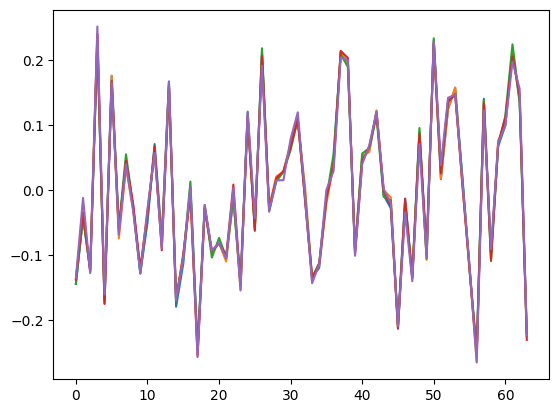

In [81]:
i = 111111
plt.plot( embeddings[cand0[i][0]] )
plt.plot( embeddings[cand0[i][1]] )
plt.plot( embeddings[cand0[i][2]] )
plt.plot( embeddings[cand0[i][3]] )
plt.plot( embeddings[cand0[i][-1]] )

52

In [98]:
files = (
    #list(glob('fold/train-full-split*')) +
    #list(glob('fold/valid-trim-split*'))
    #list(glob('fold/test-full-split*')) 
    list(glob('fold/test-trim-split*'))
)
print(len(files))

1


In [99]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
train['n'] = train.groupby('session')['aid'].cumcount()
train = train.loc[train['n']==0].reset_index(drop=True)
train = train.to_pandas()
gc.collect()
train

session      aid          ts  type  n
0      12899780   736515  1661724136     0  0
1      12899800   609871  1661724004     0  0
2      12899820   986164  1661724007     0  0
3      12899830  1838106  1661724189     0  0
4      12899840   409354  1661724012     0  0
...         ...      ...         ...   ... ..
82375  14571400    52741  1662328625     1  0
82376  14571410  1518542  1662328586     0  0
82377  14571430   903014  1662328616     1  0
82378  14571450   723612  1662328621     0  0
82379  14571470   652481  1662328650     0  0

[82380 rows x 5 columns]

In [100]:
train['cand'] = train.aid.map(cand0)
train

session      aid          ts  type  n  \
0      12899780   736515  1661724136     0  0   
1      12899800   609871  1661724004     0  0   
2      12899820   986164  1661724007     0  0   
3      12899830  1838106  1661724189     0  0   
4      12899840   409354  1661724012     0  0   
...         ...      ...         ...   ... ..   
82375  14571400    52741  1662328625     1  0   
82376  14571410  1518542  1662328586     0  0   
82377  14571430   903014  1662328616     1  0   
82378  14571450   723612  1662328621     0  0   
82379  14571470   652481  1662328650     0  0   

                                                    cand  
0      [1634532, 1423278, 1015273, 561852, 1164717, 1...  
1      [1281853, 820996, 1159135, 1480396, 286223, 15...  
2      [1178858, 757256, 1026997, 727741, 1156699, 12...  
3      [1074394, 465029, 459933, 156241, 912702, 6974...  
4      [1201597, 1602440, 1242619, 1375513, 23307, 61...  
...                                                  ...  
82375  [558125, 359115, 988443, 479936, 1263570, 7983...  
82376  [958218, 264038, 1617925, 232643, 515394, 8552...  
82377  [1099376, 1780619, 1250786, 787312, 957408, 84...  
82378  [905993, 537304, 1689819, 662462, 341140, 1597...  
82379  [873436, 1181163, 1035827, 1564476, 933537, 11...  

[82380 rows x 6 columns]

In [101]:
res = train.set_index('session')['cand'].to_dict()
len(res)

82380

In [102]:
label = pd.concat([
    pd.read_parquet('fold/labels-test.parquet'),
    pd.read_parquet('fold/labels.parquet')
])
label = label.loc[label['type']=='clicks'].copy().reset_index(drop=True)
label['cand'] = label['session'].map(res)
label = label.loc[label['cand'].notnull()]
#label['cand'].apply(len).value_counts()
label['hit'] = label.apply(lambda x: len(set(x.ground_truth).intersection(set(x.cand))), axis=1)
label['hit'].mean()
#0.21504005826656955

0.21504005826656955

In [139]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, True]).reset_index(drop=True)

#train['ids'] = np.arange(train.shape[0])
train['n'] = train.groupby('session')['ts'].cumcount()
train['day'] = train['ts'] - train['ts'].min()
train['day'] = ((train['day']-4*60*60) // (24*60*60)).astype('int8') 
train['day'] = train['day'].clip(0, 100)
train['hour'] = (train['ts'] // (60*60)).astype('int32') 
freemem(train)

print(train.shape)
train.head()

(2322090, 7)


session      aid          ts  type  n  day    hour
0  11098528    11830  1661119200     0  0    0  461422
1  11098535   745365  1661119202     0  0    0  461422
2  11098535   745365  1661119263     1  1    0  461422
3  11098535   896972  1661119564     0  2    0  461422
4  11098535  1750442  1661119577     0  3    0  461422

In [140]:
train['sid'] = (train['session'] * 35 + train['day']).factorize()[0]

train['prev_type'] = train.groupby('sid')['type'].shift(1).fillna(0)
train['delta_sid'] = train.groupby('sid')['ts'].shift(1)
train['delta_sid'] = ((train['ts'] - train['delta_sid']).fillna(0) // (2*60*60)).astype('int8')
train.loc[train.delta_sid  <3, 'delta_sid'] = 0
train.loc[(train.delta_sid>=3)|((train.type==0)&(train.prev_type==2)&(train.delta_sid>0)), 'delta_sid'] = 1
train['delta_sid'] = train.groupby('sid')['delta_sid'].cumsum()
del train['prev_type']
train['sid'] = (train['sid'] * 10 + train['delta_sid']).factorize()[0]
del train['delta_sid']
train['sid'].nunique()

525592

In [141]:
for lag in range(4, -1, -1):
    train[f'lag{lag}'] = train.groupby('session')['aid'].shift(lag).fillna(lag)

# for lag in range(1, 6):
#     train[f'led{lag}'] = train.groupby('session')['aid'].shift(-lag).fillna(lag)
del train['aid']
gc.collect()
train.head(60)

session          ts  type   n  day    hour  sid     lag4     lag3  \
0   11098528  1661119200     0   0    0  461422    0        4        3   
1   11098535  1661119202     0   0    0  461422    1        4        3   
2   11098535  1661119263     1   1    0  461422    1        4        3   
3   11098535  1661119564     0   2    0  461422    1        4        3   
4   11098535  1661119577     0   3    0  461422    1        4   745365   
5   11098535  1661119619     0   4    0  461422    1   745365   745365   
6   11098535  1661119688     0   5    0  461422    1   745365   896972   
7   11098535  1661119739     0   6    0  461422    1   896972  1750442   
8   11098535  1661119823     0   7    0  461422    1  1750442   803918   
9   11098535  1661120219     0   8    0  461422    1   803918   803918   
10  11098535  1661173474     0   9    0  461437    2   803918  1750442   
11  11098538  1661119202     0   0    0  461422    3        4        3   
12  11098538  1661119220     0   1    0  461422    3        4        3   
13  11098538  1661159281     1   2    0  461433    4        4        3   
14  11098538  1661159607     2   3    0  461433    4        4   388376   
15  11098538  1661272286     0   4    1  461464    5   388376  1711586   
16  11098538  1661360936     0   5    2  461489    6  1711586  1711586   
17  11098538  1661361046     0   6    2  461489    6  1711586  1711586   
18  11098538  1661361083     0   7    2  461489    6  1711586  1711586   
19  11098538  1661361196     0   8    2  461489    6  1711586  1172033   
20  11098538  1661361525     0   9    2  461489    6  1172033  1393077   
21  11098538  1661361603     0  10    2  461489    6  1393077  1684753   
22  11098538  1661361645     0  11    2  461489    6  1684753  1028575   
23  11098538  1661361711     0  12    2  461489    6  1028575  1760342   
24  11098538  1661361776     0  13    2  461489    6  1760342   987426   
25  11098538  1661361887     0  14    2  461489    6   987426  1111404   
26  11098538  1661361943     0  15    2  461489    6  1111404  1317439   
27  11098538  1661362061     0  16    2  461489    6  1317439  1550143   
28  11098538  1661362146     0  17    2  461489    6  1550143  1452081   
29  11098538  1661362233     0  18    2  461489    6  1452081   218349   
30  11098538  1661362852     0  19    2  461489    6   218349   984100   
31  11098538  1661362986     0  20    2  461489    6   984100    90427   
32  11098538  1661363042     0  21    2  461489    6    90427  1378595   
33  11098538  1661363085     0  22    2  461489    6  1378595   523982   
34  11098538  1661363429     0  23    2  461489    6   523982   767357   
35  11098538  1661363497     0  24    2  461489    6   767357   649126   
36  11098538  1661363651     0  25    2  461489    6   649126  1737484   
37  11098538  1661363736     0  26    2  461489    6  1737484  1126828   
38  11098538  1661364482     0  27    2  461490    6  1126828  1289587   
39  11098538  1661364530     0  28    2  461490    6  1289587   717871   
40  11098542  1661119202     0   0    0  461422    7        4        3   
41  11098542  1661119232     1   1    0  461422    7        4        3   
42  11098542  1661119251     0   2    0  461422    7        4        3   
43  11098542  1661119299     1   3    0  461422    7        4   872480   
44  11098542  1661119324     0   4    0  461422    7   872480   872480   
45  11098542  1661119367     0   5    0  461422    7   872480   414933   
46  11098542  1661119414     0   6    0  461422    7   414933   414933   
47  11098542  1661119453     1   7    0  461422    7   414933   753509   
48  11098542  1661119463     0   8    0  461422    7   753509   593711   
49  11098542  1661119482     0   9    0  461422    7   593711   976283   
50  11098542  1661119509     1  10    0  461422    7   976283   976283   
51  11098542  1661119517     1  11    0  461422    7   976283   412549   
52  11098542  1661119537     0  12    0  461422    7   412549  1361230   
53  11098

In [142]:
train = train.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
train['n'] = train.groupby('session')['ts'].cumcount()
train = train.loc[train['n'] == 0].copy().reset_index(drop=True)
train.head()

session          ts  type  n  day    hour  sid     lag4     lag3    lag2  \
0  11098528  1661119200     0  0    0  461422    0        4        3       2   
1  11098535  1661173474     0  0    0  461437    2   803918  1750442  767201   
2  11098538  1661364530     0  0    2  461490    6  1289587   717871  703265   
3  11098542  1661119915     0  0    0  461422    7  1798698   708196  708196   
4  11098545  1661716124     0  0    6  461587   12    14956  1233788   14956   

      lag1     lag0  
0        1    11830  
1   745365   745365  
2  1550143  1263747  
3   594491  1571098  
4  1063103    14956

In [143]:
emb4 = embeddings[train['lag4'].values.get()]
emb3 = embeddings[train['lag3'].values.get()]
emb2 = embeddings[train['lag2'].values.get()]
emb1 = embeddings[train['lag1'].values.get()]
emb0 = embeddings[train['lag0'].values.get()]
embday = embeddings_day[train['day'].values.get()]
emb0.shape, embday.shape

((433823, 64), (433823, 64))

In [144]:
e1 = normalize(6*emb4 + 7*emb3 + 8*emb2 + 9*emb1 + 10*emb0 + embday)
tgt = normalize(embeddings)

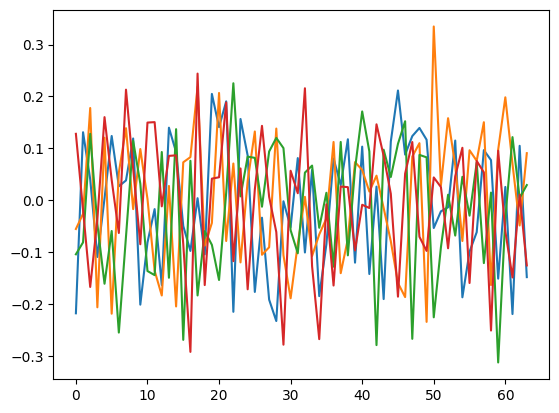

In [145]:
plt.plot( e1[0] )
plt.plot( e1[1] )
plt.plot( tgt[0] )
plt.plot( tgt[1] )

In [146]:
valind, valdist = torch_similarity(e1, tgt, 100, 384)
gc.collect()

100%|██████████| 1130/1130 [00:45<00:00, 24.57it/s]


0

In [147]:
fmcands = {ses: list(valind[i]) for i, ses in enumerate(train['session'].values.get())}
fmcands[11098528]

[1732105,
 29185,
 11830,
 42241,
 1180215,
 310828,
 1528096,
 185813,
 1389344,
 1363504,
 961040,
 1314027,
 1135189,
 1349873,
 1264628,
 136648,
 173784,
 135684,
 1342705,
 560802,
 298453,
 884502,
 1517680,
 57272,
 657625,
 1346395,
 1185664,
 1751193,
 70367,
 1327887,
 173432,
 1579280,
 1457930,
 876129,
 1082069,
 1422808,
 843124,
 782303,
 1046949,
 1348741,
 423884,
 271067,
 307904,
 1681241,
 850318,
 643712,
 1689044,
 1197172,
 1363777,
 135833,
 171093,
 1478597,
 34279,
 115542,
 1078007,
 826102,
 1676047,
 1261664,
 647142,
 1450282,
 148692,
 39409,
 1346259,
 306706,
 1215481,
 916278,
 1180288,
 305650,
 641514,
 280066,
 1763276,
 524881,
 1764621,
 1063941,
 293000,
 816463,
 978502,
 1496360,
 1182614,
 1312119,
 588923,
 505574,
 745300,
 1759697,
 1599671,
 1433806,
 1441971,
 450146,
 749124,
 696392,
 89556,
 134667,
 1603018,
 673262,
 1666688,
 1344164,
 120025,
 819844,
 30479,
 914010]

In [148]:
with open('oof/fm8_top10_cands_valid.pkl', 'wb') as f:
    pickle.dump(fmcands, f)

In [149]:
files = (
    #list(glob('fold/train-full-split*')) +
    #list(glob('fold/valid-trim-split*'))
    #list(glob('fold/test-full-split*')) 
    list(glob('fold/test-trim-split*'))
)
print(len(files))

1


In [150]:
train = pd.read_parquet(files)
train = cudf.from_pandas(train); gc.collect()
train = train.sort_values(['session', 'ts'], ascending=[True, True]).reset_index(drop=True)

#train['ids'] = np.arange(train.shape[0])
train['n'] = train.groupby('session')['ts'].cumcount()
train['day'] = train['ts'] - train['ts'].min()
train['day'] = ((train['day']-4*60*60) // (24*60*60)).astype('int8') 
train['day'] = train['day'].clip(0, 100)
train['hour'] = (train['ts'] // (60*60)).astype('int32') 
freemem(train)

print(train.shape)
train.head()

(452070, 7)


session      aid          ts  type  n  day    hour
0  12899780  1142000  1661724000     0  0    0  461590
1  12899780   582732  1661724058     0  1    0  461590
2  12899780   973453  1661724109     0  2    0  461590
3  12899780   736515  1661724136     0  3    0  461590
4  12899800   609871  1661724004     0  0    0  461590

In [151]:
train['sid'] = (train['session'] * 35 + train['day']).factorize()[0]

train['prev_type'] = train.groupby('sid')['type'].shift(1).fillna(0)
train['delta_sid'] = train.groupby('sid')['ts'].shift(1)
train['delta_sid'] = ((train['ts'] - train['delta_sid']).fillna(0) // (2*60*60)).astype('int8')
train.loc[train.delta_sid  <3, 'delta_sid'] = 0
train.loc[(train.delta_sid>=3)|((train.type==0)&(train.prev_type==2)&(train.delta_sid>0)), 'delta_sid'] = 1
train['delta_sid'] = train.groupby('sid')['delta_sid'].cumsum()
del train['prev_type']
train['sid'] = (train['sid'] * 10 + train['delta_sid']).factorize()[0]
del train['delta_sid']
train['sid'].nunique()

94558

In [152]:
for lag in range(4, -1, -1):
    train[f'lag{lag}'] = train.groupby('session')['aid'].shift(lag).fillna(lag)

# for lag in range(1, 6):
#     train[f'led{lag}'] = train.groupby('session')['aid'].shift(-lag).fillna(lag)
del train['aid']
gc.collect()
train.head(60)

session          ts  type   n  day    hour  sid     lag4     lag3  \
0   12899780  1661724000     0   0    0  461590    0        4        3   
1   12899780  1661724058     0   1    0  461590    0        4        3   
2   12899780  1661724109     0   2    0  461590    0        4        3   
3   12899780  1661724136     0   3    0  461590    0        4  1142000   
4   12899800  1661724004     0   0    0  461590    1        4        3   
5   12899820  1661724007     0   0    0  461590    2        4        3   
6   12899830  1661724010     0   0    0  461590    3        4        3   
7   12899830  1661724040     0   1    0  461590    3        4        3   
8   12899830  1661724104     0   2    0  461590    3        4        3   
9   12899830  1661724189     0   3    0  461590    3        4   552652   
10  12899840  1661724012     0   0    0  461590    4        4        3   
11  12899860  1661724015     0   0    0  461590    5        4        3   
12  12899860  1661724036     0   1    0  461590    5        4        3   
13  12899860  1661763355     0   2    0  461600    6        4        3   
14  12899860  1661763559     0   3    0  461600    6        4   703118   
15  12899860  1661776477     2   4    0  461604    6   703118   850306   
16  12899860  1661776477     2   5    0  461604    6   850306   542997   
17  12899870  1661724017     0   0    0  461590    7        4        3   
18  12899870  1661724158     0   1    0  461590    7        4        3   
19  12899870  1661724295     0   2    0  461590    7        4        3   
20  12899870  1661724407     0   3    0  461590    7        4   911935   
21  12899870  1661724455     0   4    0  461590    7   911935  1133362   
22  12899870  1661724461     0   5    0  461590    7  1133362  1329696   
23  12899870  1661724475     0   6    0  461590    7  1329696  1010011   
24  12899870  1661724573     0   7    0  461590    7  1010011  1329696   
25  12899870  1661724630     0   8    0  461590    7  1329696  1133362   
26  12899870  1661724806     0   9    0  461590    7  1133362  1718379   
27  12899870  1661725136     0  10    0  461590    7  1718379  1133362   
28  12899870  1661725240     0  11    0  461590    7  1133362  1494552   
29  12899870  1661725338     0  12    0  461590    7  1494552  1499838   
30  12899870  1661725492     1  13    0  461590    7  1499838   911935   
31  12899870  1661725502     0  14    0  461590    7   911935   827431   
32  12899870  1661725514     0  15    0  461590    7   827431  1610636   
33  12899870  1661725620     1  16    0  461590    7  1610636  1190660   
34  12899870  1661725663     0  17    0  461590    7  1190660   827431   
35  12899870  1661725879     0  18    0  461590    7   827431   525799   
36  12899870  1661749217     0  19    0  461597    8   525799   155302   
37  12899870  1661749246     1  20    0  461597    8   155302   911935   
38  12899870  1661749279     0  21    0  461597    8   911935   911935   
39  12899870  1661749338     1  22    0  461597    8   911935    36155   
40  12899870  1661749342     0  23    0  461597    8    36155    39165   
41  12899870  1661752425     0  24    0  461597    8    39165   998432   
42  12899870  1661752476     1  25    0  461597    8   998432   998432   
43  12899870  1661752482     0  26    0  461597    8   998432  1619662   
44  12899870  1661752555     0  27    0  461597    8  1619662   378389   
45  12899870  1661752846     2  28    0  461598    8   378389   378389   
46  12899870  1661752846     2  29    0  461598    8   378389  1025223   
47  12899870  1661752846     2  30    0  461598    8  1025223   998432   
48  12899870  1661752846     2  31    0  461598    8   998432  1499838   
49  12899870  1661752846     2  32    0  461598    8  1499838  1133362   
50  12899870  1661752846     2  33    0  461598    8  1133362   911935   
51  12899870  1661752846     2  34    0  461598    8   911935  1622423   
52  12899870  1661752846     2  35    0  461598    8  1622423   998432   
53  12899

In [153]:
train = train.sort_values(['session', 'ts'], ascending=[True, False]).reset_index(drop=True)
train['n'] = train.groupby('session')['ts'].cumcount()
train = train.loc[train['n'] == 0].copy().reset_index(drop=True)
train.head()

session          ts  type  n  day    hour  sid  lag4     lag3     lag2  \
0  12899780  1661724136     0  0    0  461590    0     4  1142000   582732   
1  12899800  1661724004     0  0    0  461590    1     4        3        2   
2  12899820  1661724007     0  0    0  461590    2     4        3        2   
3  12899830  1661724189     0  0    0  461590    3     4   552652  1063368   
4  12899840  1661724012     0  0    0  461590    4     4        3        2   

      lag1     lag0  
0   973453   736515  
1        1   609871  
2        1   986164  
3  1063368  1838106  
4        1   409354

In [154]:
emb4 = embeddings[train['lag4'].values.get()]
emb3 = embeddings[train['lag3'].values.get()]
emb2 = embeddings[train['lag2'].values.get()]
emb1 = embeddings[train['lag1'].values.get()]
emb0 = embeddings[train['lag0'].values.get()]
embday = embeddings_day[train['day'].values.get()]
emb0.shape, embday.shape

((82380, 64), (82380, 64))

In [155]:
e1 = normalize(6*emb4 + 7*emb3 + 8*emb2 + 9*emb1 + 10*emb0 + embday)
tgt = normalize(embeddings)

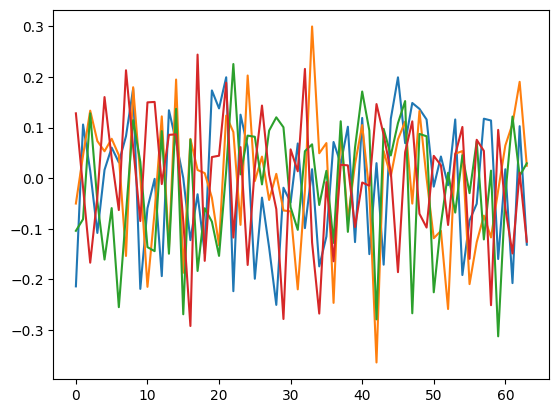

In [156]:
plt.plot( e1[0] )
plt.plot( e1[1] )
plt.plot( tgt[0] )
plt.plot( tgt[1] )

In [157]:
valind, valdist = torch_similarity(e1, tgt, 100, 384)
gc.collect()

100%|██████████| 215/215 [00:08<00:00, 24.44it/s]


0

In [158]:
fmcands = {ses: list(valind[i]) for i, ses in enumerate(train['session'].values.get())}
fmcands[12899780]

[639748,
 1351549,
 639338,
 1714212,
 1353608,
 702689,
 1852385,
 574736,
 600357,
 1455269,
 899991,
 1407866,
 133267,
 560546,
 915891,
 972514,
 341480,
 1515511,
 1541044,
 409589,
 209046,
 1305555,
 305488,
 241151,
 760730,
 584238,
 857504,
 1789442,
 1643001,
 1341824,
 813925,
 480564,
 1438697,
 737575,
 1269469,
 609953,
 659192,
 621108,
 1016291,
 224856,
 1455108,
 837552,
 128619,
 434061,
 671286,
 77422,
 1555373,
 1670185,
 1191527,
 1370211,
 42610,
 1013576,
 308468,
 1516868,
 50980,
 1420007,
 2589,
 267561,
 1160357,
 158287,
 1283255,
 1394243,
 1537673,
 1315227,
 255099,
 1660665,
 1344758,
 456058,
 386169,
 946621,
 409303,
 464550,
 137088,
 953204,
 720437,
 1028932,
 1053332,
 97206,
 1346082,
 1509888,
 99847,
 1647971,
 989131,
 1335882,
 1115747,
 1661236,
 282253,
 1153038,
 510369,
 199681,
 1123537,
 238389,
 185878,
 1705688,
 1758094,
 630697,
 26940,
 998657,
 50708,
 123535]

In [159]:
with open('oof/fm8_top10_cands_test.pkl', 'wb') as f:
    pickle.dump(fmcands, f)  

In [163]:
label = pd.concat([
    pd.read_parquet('fold/labels-test.parquet'),
    #pd.read_parquet('fold/labels.parquet')
])
label = label.loc[label['type']=='clicks'].copy().reset_index(drop=True)
label

session    type ground_truth
0      12899780  clicks    [1142000]
1      12899800  clicks     [609871]
2      12899820  clicks     [986164]
3      12899830  clicks    [1383942]
4      12899840  clicks    [1333534]
...         ...     ...          ...
82375  14571400  clicks     [962285]
82376  14571410  clicks    [1345697]
82377  14571430  clicks    [1162324]
82378  14571450  clicks      [51144]
82379  14571470  clicks    [1181163]

[82380 rows x 3 columns]

In [164]:
label['cand'] = label['session'].map(fmcands)
label

session    type ground_truth  \
0      12899780  clicks    [1142000]   
1      12899800  clicks     [609871]   
2      12899820  clicks     [986164]   
3      12899830  clicks    [1383942]   
4      12899840  clicks    [1333534]   
...         ...     ...          ...   
82375  14571400  clicks     [962285]   
82376  14571410  clicks    [1345697]   
82377  14571430  clicks    [1162324]   
82378  14571450  clicks      [51144]   
82379  14571470  clicks    [1181163]   

                                                    cand  
0      [639748, 1351549, 639338, 1714212, 1353608, 70...  
1      [609871, 977761, 232730, 155843, 1523052, 5264...  
2      [1010579, 1301436, 1167765, 1263928, 1532301, ...  
3      [99870, 1376476, 1807958, 1690944, 1018129, 21...  
4      [409354, 122458, 1719123, 1602440, 1201597, 15...  
...                                                  ...  
82375  [52741, 445831, 1089191, 1840984, 1184342, 127...  
82376  [1518542, 232643, 1744143, 593599, 693214, 958...  
82377  [903014, 264709, 464721, 1811992, 1220561, 125...  
82378  [723612, 755127, 905993, 423558, 527568, 13843...  
82379  [873436, 543649, 652481, 1181163, 827846, 1637...  

[82380 rows x 4 columns]

In [165]:
label['hit'] = label.apply(lambda x: len(set(x.ground_truth).intersection(set(x.cand))), axis=1)
label['hit'].mean()
#0.41299446752915986
#0.41153192522456905

0.41153192522456905